In [15]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.visualize import plot_time_series

from jre_utils.datapath import (
    factor_data_paths,
    model_built_data_paths,
    model_ready_data_paths, 
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [62]:
asset_type = "combined"
investment_asset_type = "land"

dataset_key = "transactions"
years_ahead = 2

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "gmean"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"

normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [63]:
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [64]:
core_df = pd.read_csv(model_ready_data_path)
core_df["noise"] = np.random.normal(0, 1, core_df.shape[0])

factor = "taxable_income_growth"

variables = [f"{investment_asset_type}_yearly_price_growth", factor, "noise"]
columns = group_by_columns + variables
core_df = core_df[columns].dropna()
core_df = core_df[core_df["year"] >= 2010]

tmp_df = pd.DataFrame()

for area_code in core_df["area_code"].unique():
    area_df = core_df[core_df["area_code"] == area_code]
    if area_df.shape[0] == 12:
        tmp_df = pd.concat([tmp_df, area_df])
        
core_df = tmp_df

In [65]:
core_df

,area,area_code,year,land_yearly_price_growth,taxable_income_growth,noise
3,Aichi-ken Agui-cho,23441,2010,0.044494,-0.089172,-0.527338
4,Aichi-ken Agui-cho,23441,2011,0.098042,0.023952,1.004398
5,Aichi-ken Agui-cho,23441,2012,-0.035540,0.032618,1.418517
6,Aichi-ken Agui-cho,23441,2013,-0.110412,0.013382,0.863798
7,Aichi-ken Agui-cho,23441,2014,-0.093715,0.031320,-1.126314
...,...,...,...,...,...,...
21228,Yamanashi-ken Oshino-mura,19424,2017,-0.101796,-0.080961,-1.340898
21229,Yamanashi-ken Oshino-mura,19424,2018,0.126046,0.075394,-1.000690
21230,Yamanashi-ken Oshino-mura,19424,2019,1.101751,0.099716,0.114803
21231,Yamanashi-ken Oshino-mura,19424,2020,-0.214747,-0.071295,-0.603324


In [66]:
for variable in variables:
    plot_time_series(
        area_df,
        variable,
        group_by_columns,
        granularity_columns,
        f"{variable} over time",
        width=1000,
        height=400,
        showlegend=False,
        # visible="legendonly",
        # highlight=True,
        # highlight_range=(2020, 2022)
    )

In [67]:
def get_prefecture_code(area_code):
    return int(area_code) // 1000

prefecture_codes = list(range(47 + 1)) # 0 for Japan and 1-47 for the prefectures

cross_correlation_dict = {
    area_code: {
        dep: {factor: {"lag": [], "corr": [], "corr_norm": []} for factor in variables}
        for dep in variables
    }
    for area_code in list(core_df["area_code"].unique()) + prefecture_codes
}

In [68]:
# Keep lag between -5 and 5

for area_code in core_df["area_code"].unique():
    area_df = core_df[core_df["area_code"] == area_code].sort_values(by="year", ascending=True)
    for factor in variables:
        for dep in variables:
            corr_df = area_df.set_index("year").dropna()
            dep_curve, factor_curve = corr_df[dep], corr_df[factor]

            if len(corr_df) > 0:
                zero_lag_index, min_lag, max_lag = len(factor_curve) - 1, -5, 5
                
                # Lags
                lags = np.arange(min_lag, max_lag + 1) # [-5, 5]
                
                min_index = zero_lag_index + min_lag
                max_index = zero_lag_index + max_lag + 1


                # Cross Corr
                cross_corr = np.correlate(dep_curve, factor_curve, mode="full")[min_index:max_index]

                # Normalize Cross Corr
                auto_corr_x = np.correlate(dep_curve, dep_curve)[0]
                auto_corr_y = np.correlate(factor_curve, factor_curve)[0]

                normalization_factor = np.sqrt(auto_corr_x * auto_corr_y)
                cross_corr_normalized = cross_corr / normalization_factor

                # Store
                cross_correlation_dict[area_code][dep][factor]["lag"] = lags
                cross_correlation_dict[area_code][dep][factor]["corr"] = cross_corr
                cross_correlation_dict[area_code][dep][factor][
                    "corr_norm"
                ] = cross_corr_normalized

In [69]:
# very inefficient
for prefecture_code in prefecture_codes:
    # break
    for factor in variables:
        for dep in variables:

            cross_corr_df = pd.DataFrame({"lag": []})

            for area_code in cross_correlation_dict.keys():
                if get_prefecture_code(area_code) == prefecture_code or prefecture_code == 0:
                    cross_corr_series = pd.DataFrame(
                        {
                            "lag": cross_correlation_dict[area_code][dep][factor][
                                "lag"
                            ],
                            area_code: cross_correlation_dict[area_code][dep][factor][
                                "corr_norm"
                            ],
                        }
                    )
                    cross_corr_df = cross_corr_df.merge(
                        cross_corr_series, on="lag", how="outer"
                    )

            prefecture_avg_cross_corr = (
                cross_corr_df.set_index("lag").sort_index().mean(axis=1)
            )

            cross_correlation_dict[prefecture_code][dep][factor][
                "lag"
            ] = prefecture_avg_cross_corr.index

            cross_correlation_dict[prefecture_code][dep][factor][
                "corr_norm"
            ] = prefecture_avg_cross_corr.values

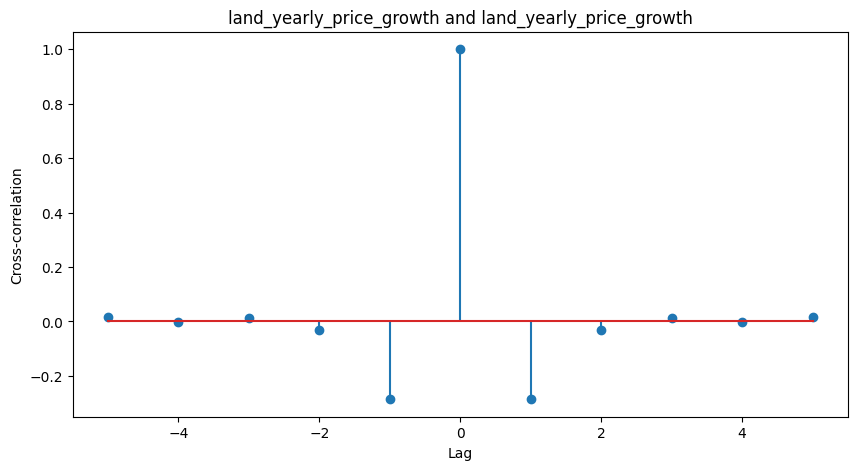

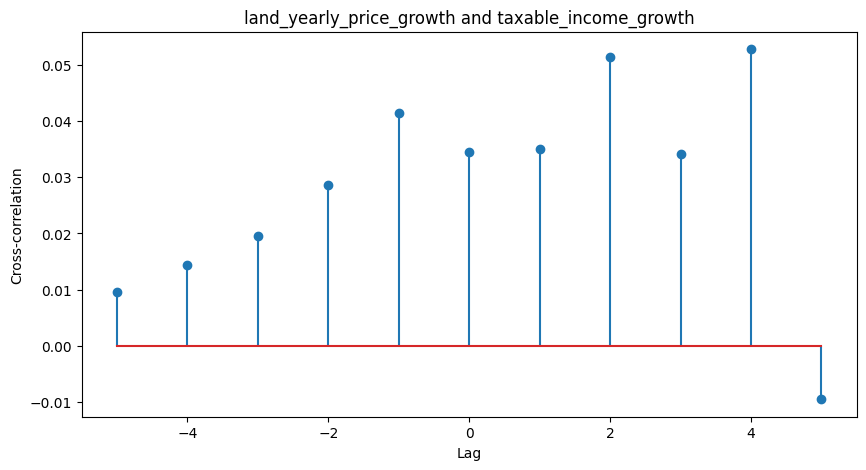

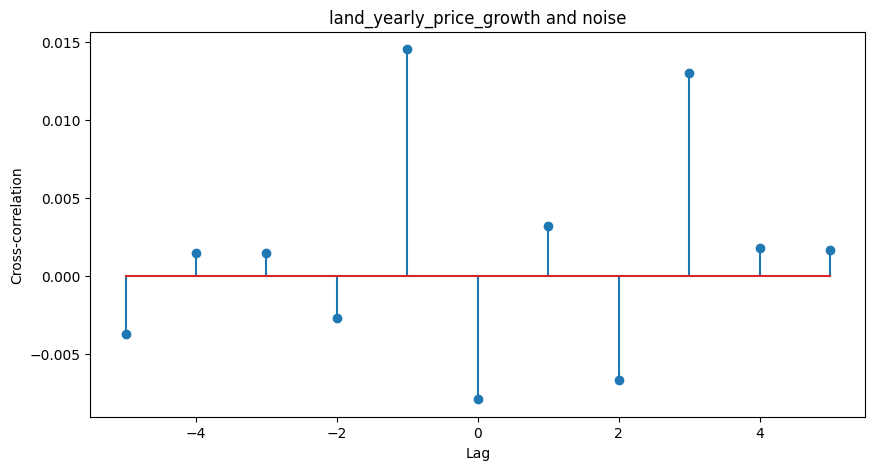

In [70]:
area_code = 0
x_var = f"{investment_asset_type}_yearly_price_growth"

for y_var in variables:
    cross_corr_norm = cross_correlation_dict[area_code][x_var][y_var]["corr_norm"]
    lags = cross_correlation_dict[area_code][x_var][y_var]["lag"]

    # Plotting the cross-correlation vs lags
    plt.figure(figsize=(10, 5))
    plt.stem(lags, cross_corr_norm)
    plt.title(f'{x_var} and {y_var}')
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.show()